# H1C IDR3 LST-Binning Inspection Notebook
### Josh Dillon

This notebook provides a sense-check for H1C IDR3 LST-binning results for one of the four epochs.

In [1]:
epoch = 0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from hera_cal.io import HERAData
import glob
from hera_cal import utils, noise, redcal, lstbin
from hera_cal.abscal import match_times
from copy import deepcopy
import os
from IPython.display import display, HTML
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# figure out which days are in the epoch
JDs = [int(path.split('/')[-1]) for path in sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/245*'))]
if epoch == 0:
    JDs = [JD for JD in JDs if JD < 2458080]
elif epoch == 1:
    JDs = [JD for JD in JDs if JD >= 2458080 and JD < 2458120]   
elif epoch == 2:
    JDs = [JD for JD in JDs if JD >= 2458120 and JD < 2458170]
elif epoch == 3:
    JDs = [JD for JD in JDs if JD >= 2458170]
print(JDs)

[2458041, 2458042, 2458043, 2458044, 2458045, 2458046, 2458047, 2458048, 2458049, 2458050, 2458051, 2458052, 2458058, 2458059, 2458062, 2458063, 2458064, 2458067, 2458068, 2458069, 2458070, 2458071, 2458072]


In [4]:
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort(fn):
    lst = float(fn.split('.LST.')[-1].split('.sum.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst
lst_bin_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/epoch_{epoch}/zen.grp1.of1.LST.*.sum.uvh5'), key=file_lst_for_sort)

In [5]:
# load data for the center file in the list
center_lst_bin_file = lst_bin_files[len(lst_bin_files) // 2]
hd = HERAData(center_lst_bin_file)
data, flags, nsamples = hd.read()

antenna_diameters is not set. Using known values for HERA.


In [6]:
# figure out which antenna numbers have more than 0 samples
ants_with_samples = set([])
for bl in nsamples:
    sample_sum = np.sum(nsamples[bl])
    if sample_sum > 0:
        for ant in utils.split_bl(bl):
            ants_with_samples.add(ant[0])

In [7]:
def Array_Plot():
    plt.figure(figsize=(8, 8), dpi=75)
    plt.scatter(np.array(list(hd.antpos.values()))[:,0], 
                np.array(list(hd.antpos.values()))[:,1], c='w', s=0)
    for ant, pos in hd.antpos.items():
        bad = ant not in ants_with_samples
        plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                        fill=(~bad), color=['grey','r'][bad]))
        plt.text(pos[0],pos[1], str(ant), va='center', ha='center', color='w')
    plt.xlabel("Antenna East-West Position (meters)")
    plt.ylabel("Antenna North-South Position (meters)")
    plt.title(f'Antenna Positions for Epoch {epoch} at LST = {np.mean(data.lsts * 12 / np.pi):.2f} hours (Flags in Red)');
    plt.axis('equal')
    plt.tight_layout()

# Figure 1: Array Configuration and Flagged Antennas

This plot shows the array configuration in the central file of the LST-binner, including flagged antennas (those involved in no baselines with any samples).

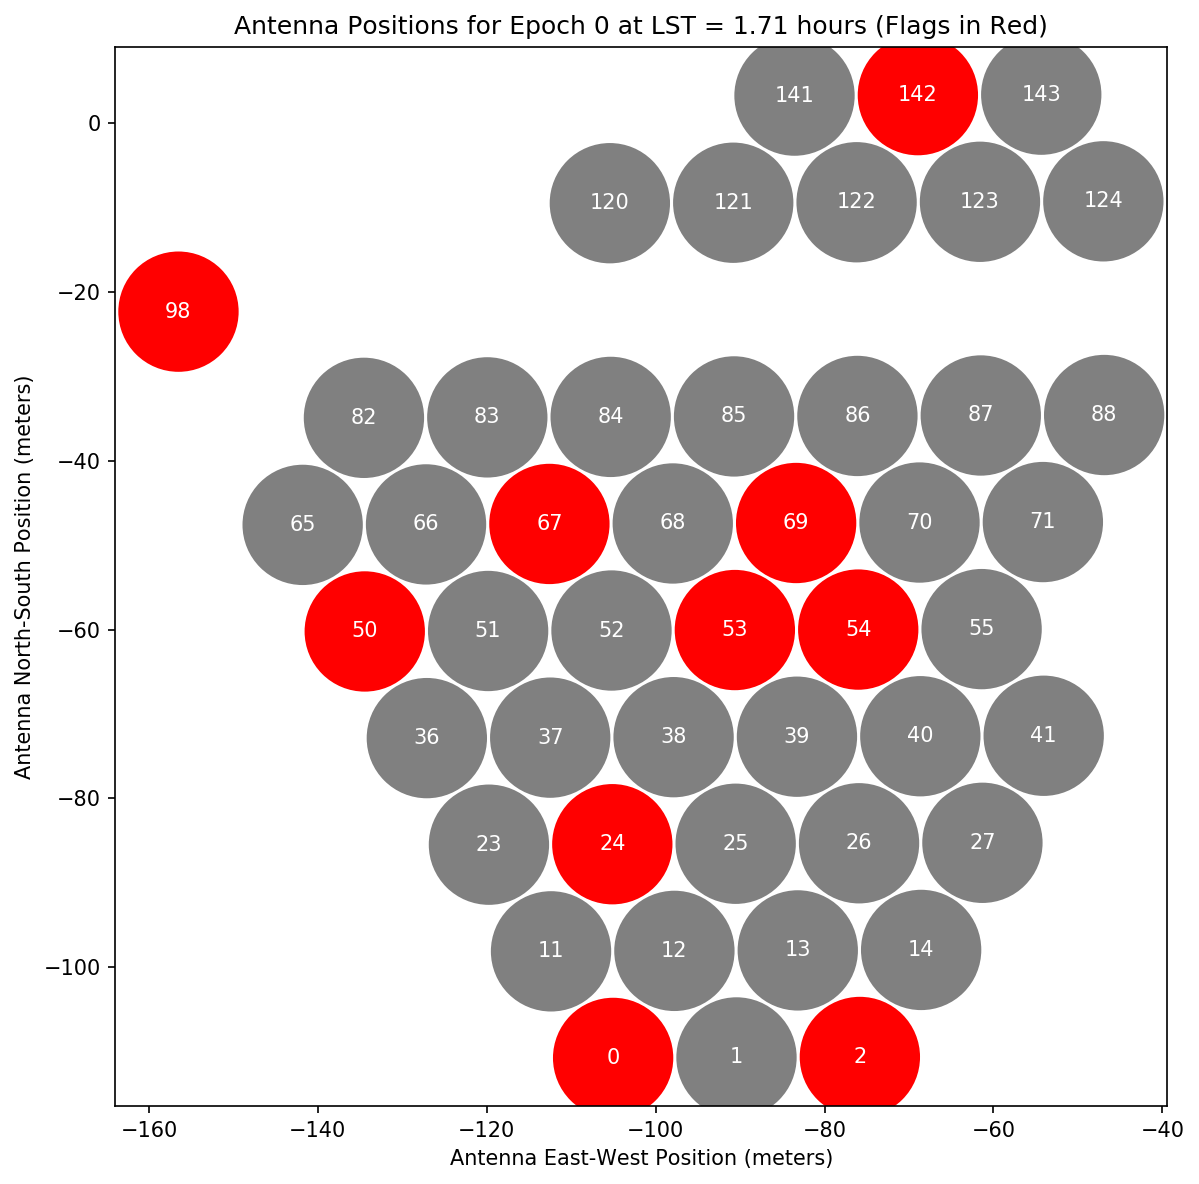

In [8]:
Array_Plot()

In [9]:
# get largest redundant groups over 40 m (so we get to see some fringes)
reds = redcal.get_reds(hd.antpos, pols=['ee', 'nn'])
ex_bls=set([bl for bl in nsamples if np.sum(nsamples[bl]) == 0])
reds = redcal.filter_reds(reds, ex_bls=ex_bls, antpos=hd.antpos, min_bl_cut=40)
reds = sorted(reds, key=len, reverse=True)

# pick out middle baselines (one per pol, generally)
bls_to_compare = [sorted(reds[n])[len(reds[n]) // 2] for n in range(2)]

In [10]:
# load bls_to_compare, starting from middle JD and continuing until we find one where the baselines are not entirely flagged
for JD in np.roll(JDs, len(JDs) // 2):
    jd_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/{JD}/*.smooth_calibrated.uvh5'))    
    files_to_load = match_times(center_lst_bin_file, jd_files)
    hd2 = HERAData(files_to_load)
    d2, f2, n2 = hd2.read(bls=bls_to_compare, axis='blt')
    if not np.any([np.all(f2[bl]) for bl in bls_to_compare]):
        break # this JD has the baselines not completely flagged

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [11]:
def Compare_To_Night():
    for bl in bls_to_compare:
        display(HTML(f'<h2>Baseline {bl}:</h2>'))
        plt.figure(figsize=(18,8))
        
        # use this to match the yrange to the LST-binned data
        ylim=[data.lsts[-1]*12/np.pi, data.lsts[0]*12/np.pi]
        
        # plot LST-binned Phase
        plt.subplot(223)
        plt.imshow(np.where(flags[bl], np.nan, np.angle(data[bl])), aspect='auto', cmap='twilight', 
                   extent=[data.freqs[0]/1e6, data.freqs[-1]/1e6, data.lsts[-1]*12/np.pi, data.lsts[0]*12/np.pi])
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.ylim(ylim)
        plt.title(f'{bl}: Epoch {epoch} LST-Binned Phase')
        plt.colorbar(label='Phase (radians)')
        
        # plot LST-binned amplitude
        plt.subplot(224)
        plt.imshow(np.where(flags[bl], np.nan, np.abs(data[bl])), aspect='auto', cmap='inferno', vmin=0,
                   extent=[data.freqs[0]/1e6, data.freqs[-1]/1e6, data.lsts[-1]*12/np.pi, data.lsts[0]*12/np.pi])
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.ylim(ylim)
        plt.title(f'{bl}: Epoch {epoch} LST-Binned Amplitude')
        plt.colorbar(label='Amplitude (Jy)')
        vmin, vmax = plt.gci().get_clim()
        
        # plot phase on single night
        plt.subplot(221)
        plt.imshow(np.where(f2[bl], np.nan, np.angle(d2[bl])), aspect='auto', cmap='twilight', 
                   extent=[d2.freqs[0]/1e6, d2.freqs[-1]/1e6, d2.lsts[-1]*12/np.pi, d2.lsts[0]*12/np.pi])
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.ylim(ylim)
        plt.title(f'{bl}: Phase on {JD}')
        plt.colorbar(label='Phase (radians)')

        # plot amplitude on single night
        plt.subplot(222)
        plt.imshow(np.where(f2[bl], np.nan, np.abs(d2[bl])), aspect='auto', cmap='inferno', vmin=vmin, vmax=vmax,
                   extent=[d2.freqs[0]/1e6, d2.freqs[-1]/1e6, d2.lsts[-1]*12/np.pi, d2.lsts[0]*12/np.pi])
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.ylim(ylim)
        plt.title(f'{bl}: Amplitude on {JD}')
        plt.colorbar(label='Amplitude (Jy)')


        plt.tight_layout()
        plt.show()
        display(HTML('<hr style="height:3px">'))

# Figure 2: Compare Single Night's Data to LST-Binned Data

Compares amplitude and phase between a single night (picked so that the baselines aren't totally flagged) and the LST-binned results.

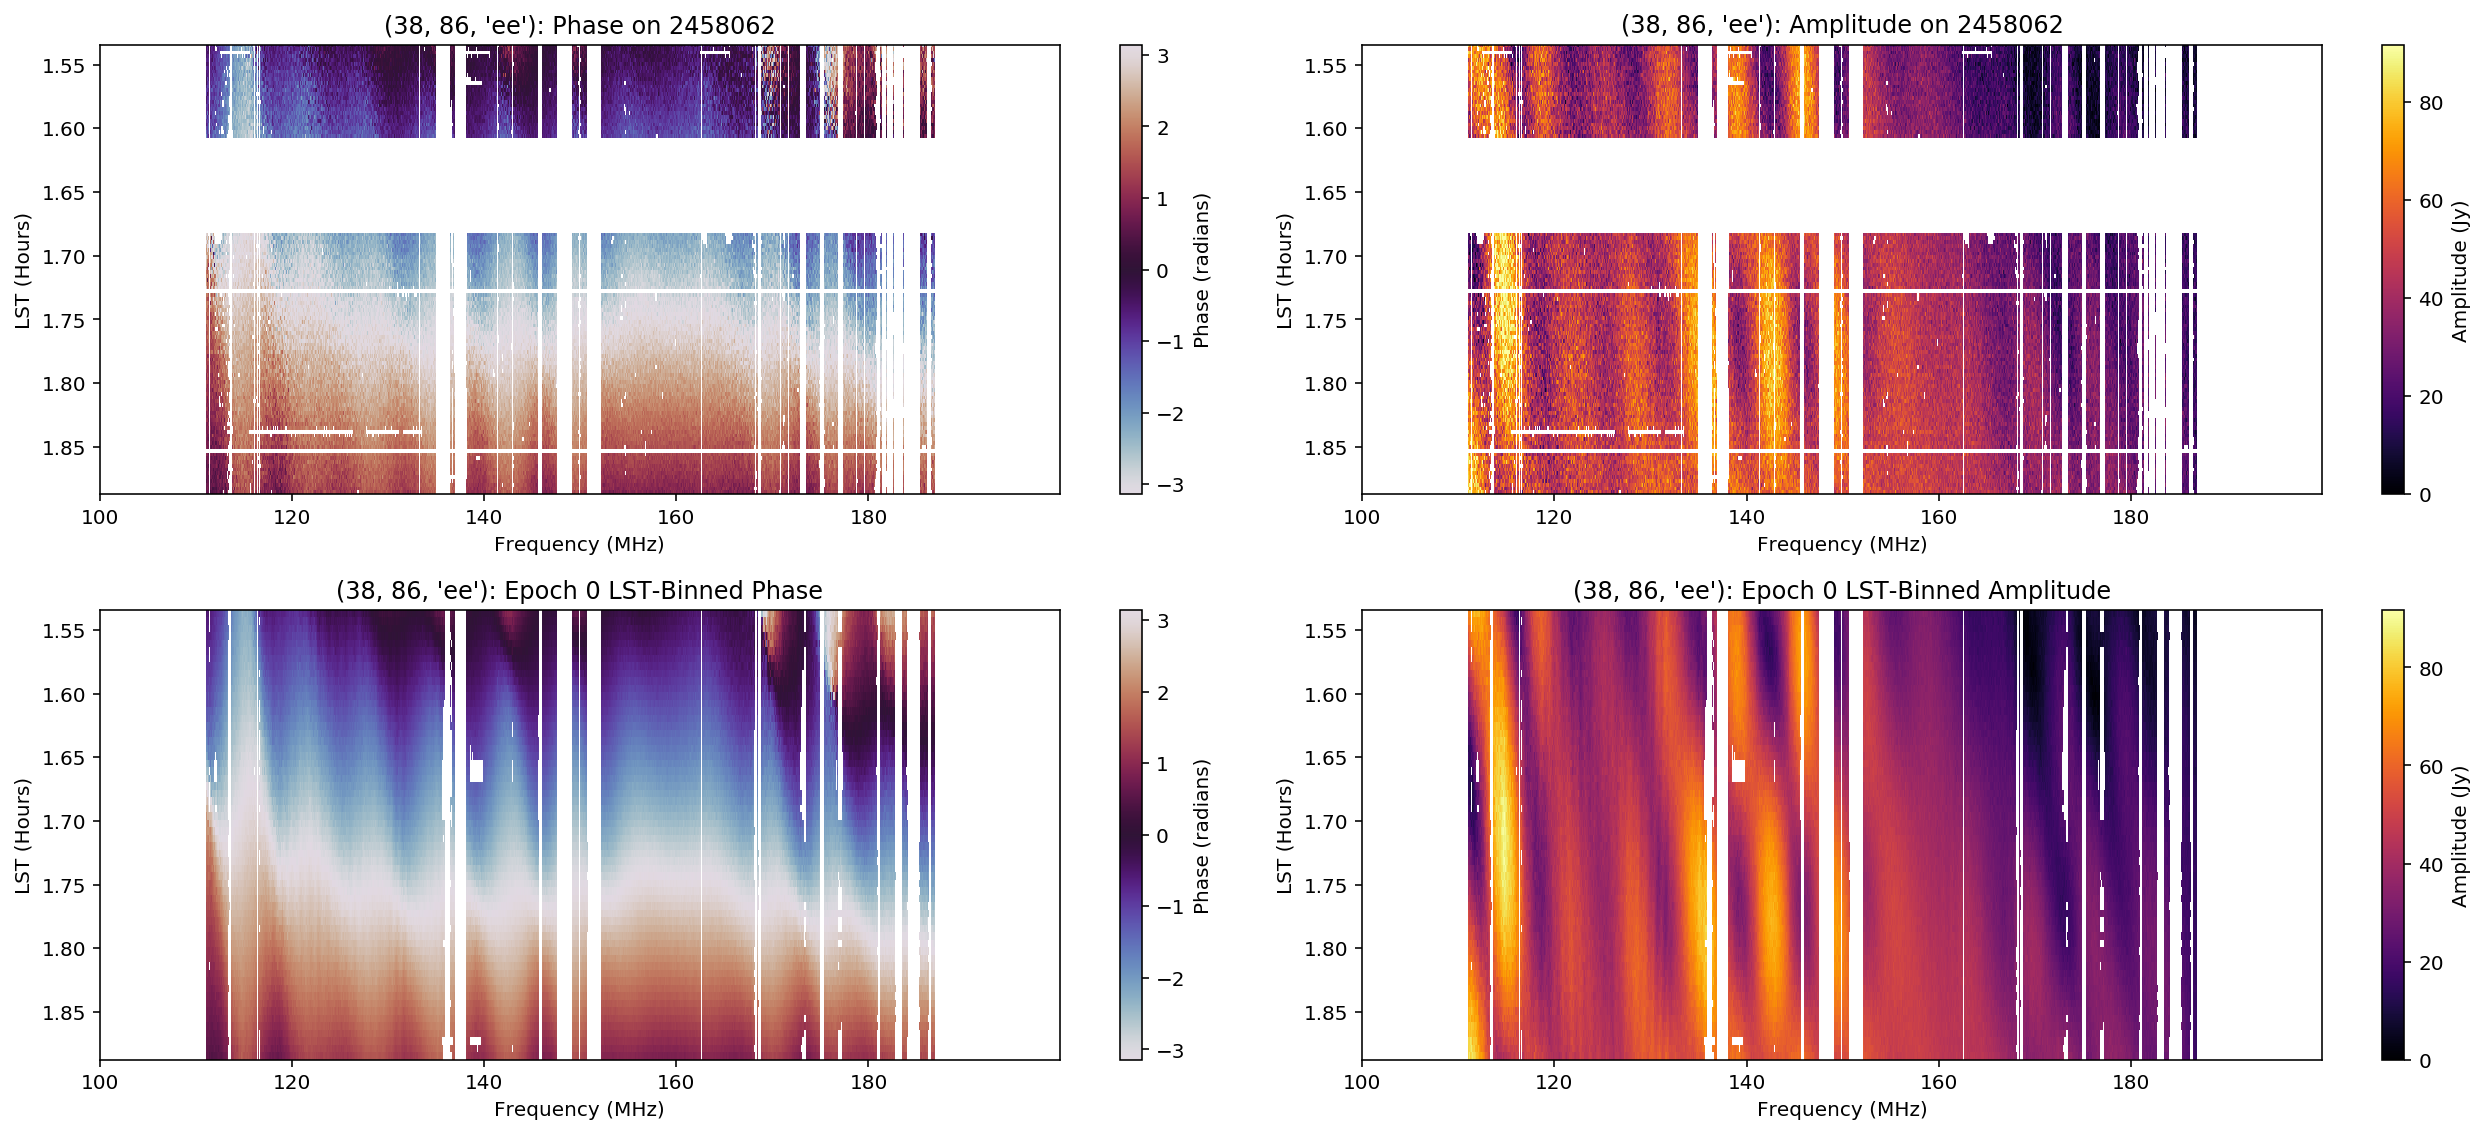

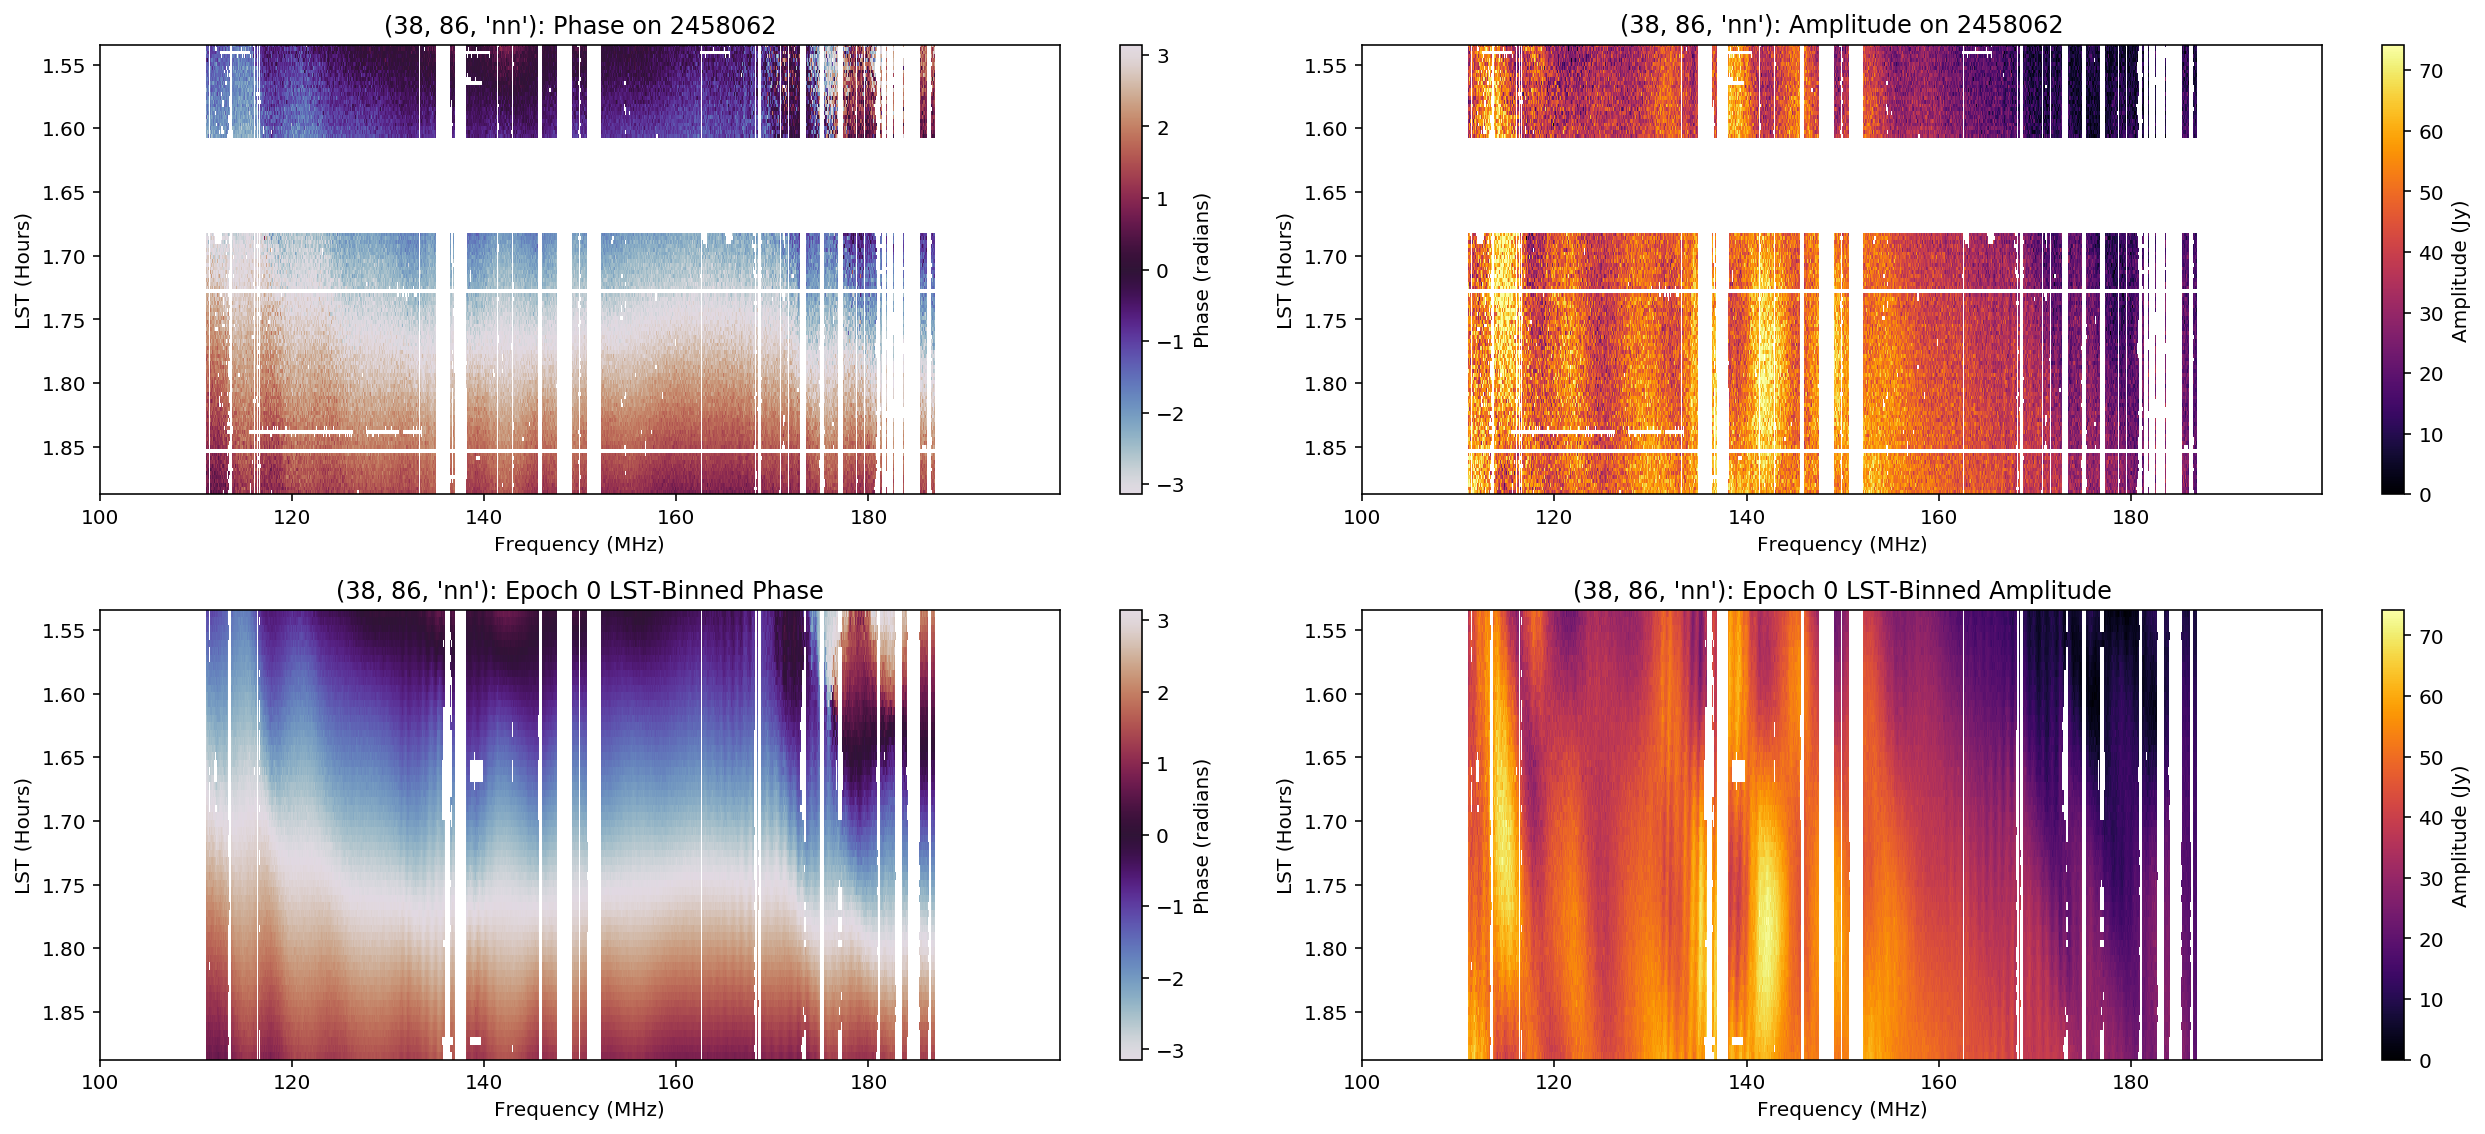

In [12]:
Compare_To_Night()

In [13]:
# get original integration time
tint = np.median(np.diff(d2.times)) * 24 * 3600

In [14]:
# load night-to-night standard deviations
std_bin_file = center_lst_bin_file.replace('.LST.', '.STD.')
hdstd = HERAData(std_bin_file)
data_std, flags_std, nsamples_std = hdstd.read()

antenna_diameters is not set. Using known values for HERA.


In [15]:
# lists to store estimates of the nosie variance in the LST-binned data products
all_obs_var = []
all_predicted_var = []
all_interleaved_var = []
all_predicted_binned_var = []

# Loop over baselines
for bl in data.bls():
    ant1, ant2 = utils.split_bl(bl)
    auto1 = utils.join_bl(ant1, ant1)
    auto2 = utils.join_bl(ant2, ant2)    
    if ant1[1] != ant2[1]:
        continue # cross polarized
    if auto1 == auto2:
        continue # ignore autocorrelations in assessing noise
    
    # Flag integrations with fewer than 10 samples
    flags_here = deepcopy(flags[bl])
    flags_here |= flags[auto1] | flags[auto2]
    flags_here |= (nsamples[bl] < 10) | (nsamples[auto1] < 10) | (nsamples[auto2] < 10)

    # Predicted night-to-night visibility variance
    predicted_var = noise.predict_noise_variance_from_autos(bl, data, dt=tint)
    predicted_var[flags_here] = np.nan
    all_predicted_var.append(predicted_var)
    
    # Observed night-to-night visibiltiy variance
    obs_var = deepcopy(data_std[bl])**2
    obs_var[flags_here] = np.nan
    obs_nsamples = deepcopy(nsamples_std[bl])
    obs_nsamples[flags_here] = np.nan
    obs_var *= (obs_nsamples / (obs_nsamples - 1))
    all_obs_var.append(obs_var)

    # Predicted visibiltiy variance after LST-binning
    predicted_binned_var = noise.predict_noise_variance_from_autos(bl, data, dt=tint, nsamples=nsamples)
    predicted_binned_var[flags_here] = np.nan
    all_predicted_binned_var.append(predicted_binned_var)    
    
    # Observed visibiltiy variance after LST-binning
    data_here = deepcopy(data[bl])
    data_here[flags_here] = np.nan
    interleaved_variance = noise.interleaved_noise_variance_estimate(data_here, kernel=[[-.5,1,-.5]])
    all_interleaved_var.append(interleaved_variance)

divide by zero encountered in true_divide


In [16]:
# average all visibiltiy variances over times and unflagged antennas
mean_obs_var = np.nanmean(np.abs(all_obs_var), axis=(0,1))
mean_predicted_var = np.nanmean(all_predicted_var, axis=(0,1))
mean_interleaved_var = np.nanmean(np.abs(all_interleaved_var), axis=(0,1))
mean_predicted_binned_var = np.nanmean(all_predicted_binned_var, axis=(0,1))

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


In [17]:
def Noise_Comparison():
    fig, ax = plt.subplots(2,2, figsize=(16,8), sharex='col', gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=.0)
    ax=ax.flatten()

    ax[0].plot(hd.freqs/1e6, mean_obs_var, lw=2, label='Night-to-Night Variance of\nData LST-Binned Together')
    ax[0].plot(hd.freqs/1e6, mean_predicted_var, lw=1, label='Predicted Variance from LST-Binned\nAutocorrelations')
    ax[0].set_ylabel('Nightly Visibility Variance (Jy$^2$) ')
    ax[0].set_title(f'Visibility Variance Across Nights at {np.round(hd.lsts[0]*12/np.pi,3)}—{np.round(hd.lsts[-1]*12/np.pi,3)} Hours LST'
                    '\n(Mean Over Unflagged Times and Baselines)')
    ax[0].legend()

    ax[1].plot(hd.freqs/1e6, mean_interleaved_var, lw=2, label='Variance from Frequency-Interleaving\nof LST-Binned Data')
    ax[1].plot(hd.freqs/1e6, mean_predicted_binned_var, lw=1, label='Predicted Variance from LST-Binned\nAutocorrelations and N$_{samples}$')
    ax[1].set_ylabel('LST-Binned Visibility Variance (Jy$^2$)')
    ax[1].set_title(f'Variance of LST-Binned Visibilities at {np.round(hd.lsts[0]*12/np.pi,3)}—{np.round(hd.lsts[-1]*12/np.pi,3)} Hours LST'
                    '\n(Mean Over Unflagged Times and Baselines)')
    ax[1].legend()

    ax[2].plot(hd.freqs/1e6, mean_obs_var/mean_predicted_var, 'k-', lw=1)
    favg_rat = np.nanmean(mean_obs_var/mean_predicted_var)
    ax[2].plot(hd.freqs/1e6, np.ones_like(hd.freqs) * favg_rat, '--', c='grey', label=f'Frequency-Averaged Ratio: {favg_rat:.3f}')
    ax[2].set_xlabel('Frequency (MHz)')
    ax[2].set_xlim([100,200])
    ax[2].set_ylim([.9, 1.5])
    ax[2].set_ylabel('Observed / Predicted')
    ax[2].legend(loc='upper right')

    ax[3].plot(hd.freqs/1e6, mean_interleaved_var/mean_predicted_binned_var, 'k-', lw=1)
    favg_rat =  np.nanmean(mean_interleaved_var/mean_predicted_binned_var)
    ax[3].plot(hd.freqs/1e6, np.ones_like(hd.freqs) * favg_rat, '--', c='grey', label=f'Frequency-Averaged Ratio: {favg_rat:.3f}')
    ax[3].set_xlabel('Frequency (MHz)')
    ax[3].set_ylim([.9, 1.5])
    ax[3].set_xlim([100,200])
    ax[3].set_ylabel('Observed / Predicted')
    ax[3].legend(loc='upper right')

    plt.tight_layout()

# Figure 3: Comparison of Noise Metrics and Predicted Noise

Comparison of noise predicted from autocorrelations (and $N_{samples}$) to the noise measured either from the standard deviation across nights or from frequency-interleaving.

Based on [Validation Test 4.0.0b](https://github.com/HERA-Team/hera-validation/blob/master/test-series/4/test-4.0.0b.ipynb) and [Aguirre et al. (2021) Figure 12](https://www.overleaf.com/project/5e7cdde364f7d40001749218) (the H1C IDR2 Validation paper).

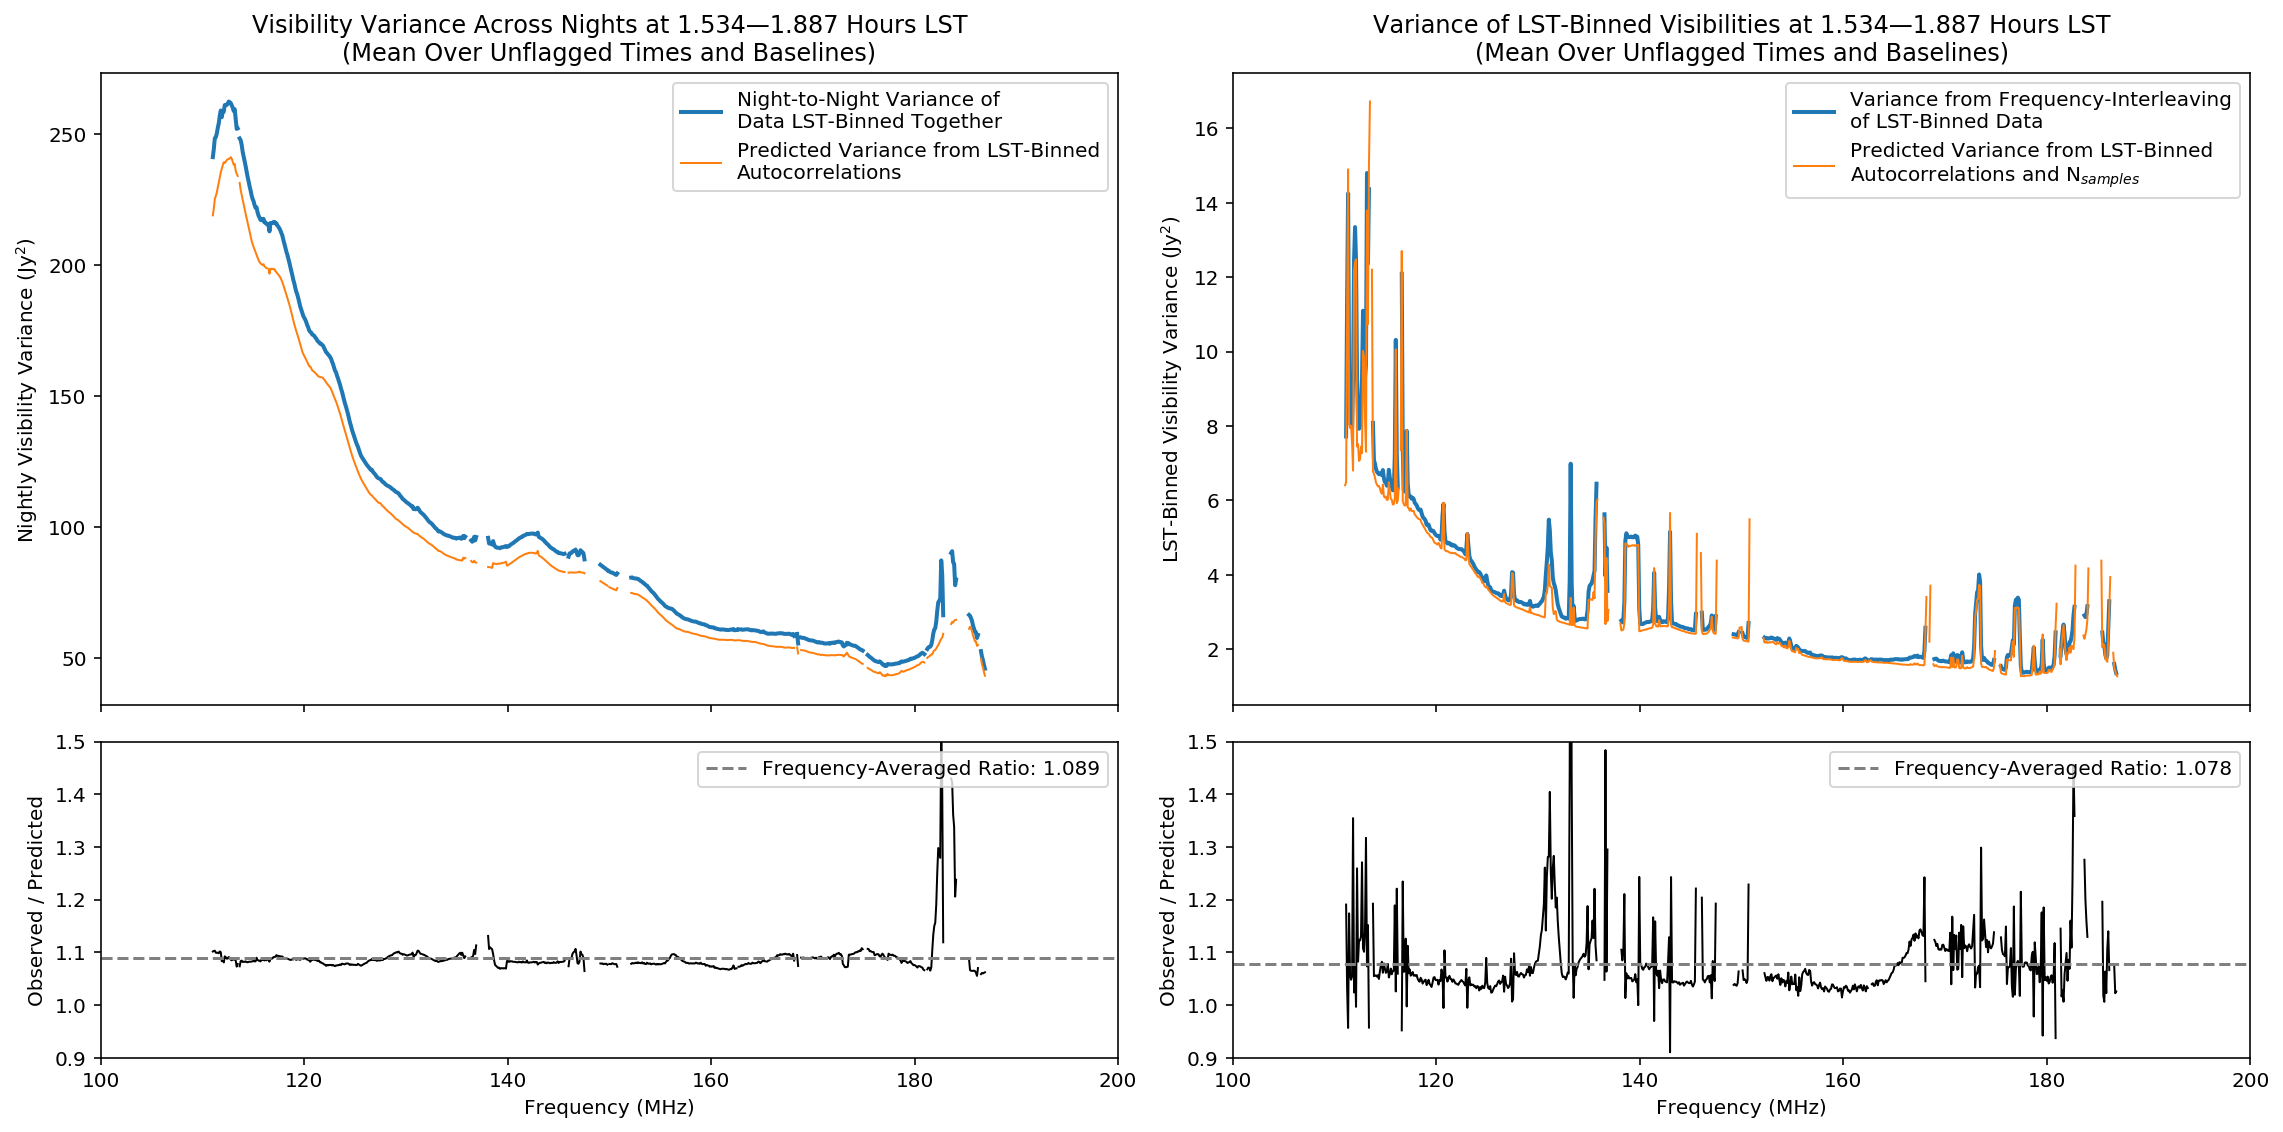

In [18]:
Noise_Comparison()

In [19]:
# pick out the baselines in the same groups but only pick the ones with the most total samples from the central file
bls_to_load = [sorted(reds[n], key=lambda bl: np.sum(nsamples[bl]))[-1] for n in range(2)]

In [20]:
# Load those baselines for all LSTs
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hd_full = HERAData(lst_bin_files)
    data_full, flags_full, nsamples_full = hd_full.read(bls=bls_to_load, axis='blt')

In [21]:
def Plot_Full_Night():
    for bl in bls_to_load:
        display(HTML(f'<h2>Baseline {bl}:</h2>'))
        plt.figure(figsize=(18,14))
        
        # handle possible wraps in LST
        extent=[data_full.freqs[0]/1e6, data_full.freqs[-1]/1e6, len(data_full.lsts), 0]
        yticks = np.linspace(0, len(data_full.lsts) - 1e-10, 10)
        yticklabels = np.round(12 / np.pi * data_full.lsts[np.floor(np.linspace(0, len(data_full.lsts) - 1e-10, 10)).astype(int)], 2)
        
        # Plot Phase
        plt.subplot(131)
        plt.imshow(np.where(flags_full[bl], np.nan, np.angle(data_full[bl])), 
                   aspect='auto', cmap='twilight', interpolation='nearest', extent=extent)
        plt.yticks(yticks, yticklabels)
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.title(f'{bl}: Epoch {epoch} LST-Binned Phase')
        plt.colorbar(label='Phase (radians)', aspect=50)

        # Plot Amplitude
        plt.subplot(132)
        plt.imshow(np.where(flags_full[bl], np.nan, np.abs(data_full[bl])), 
                     aspect='auto', cmap='inferno', interpolation='nearest', norm=LogNorm(), extent=extent)
        plt.yticks(yticks, yticklabels)    
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.title(f'{bl}: Epoch {epoch} LST-Binned Amplitude')
        plt.colorbar(label='Amplitude (Jy)', aspect=50)

        # Plot N Samples
        plt.subplot(133)
        plt.imshow(nsamples_full[bl], aspect='auto', cmap='viridis', interpolation='nearest', extent=extent)
        plt.yticks(yticks, yticklabels)
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (Hours)')
        plt.title(f'{bl}: Epoch {epoch} Samples LST-Binned')
        plt.colorbar(label='Number of Samples', aspect=50)

        plt.tight_layout()
        plt.show()
        display(HTML('<hr style="height:3px">'))

# Figure 4: Full Night Waterfalls

Full-epoch phases, amplitudes, and $N_{samples}$ for baselines from the same redundant group as above, but picked to have the maximum total samples in that group.

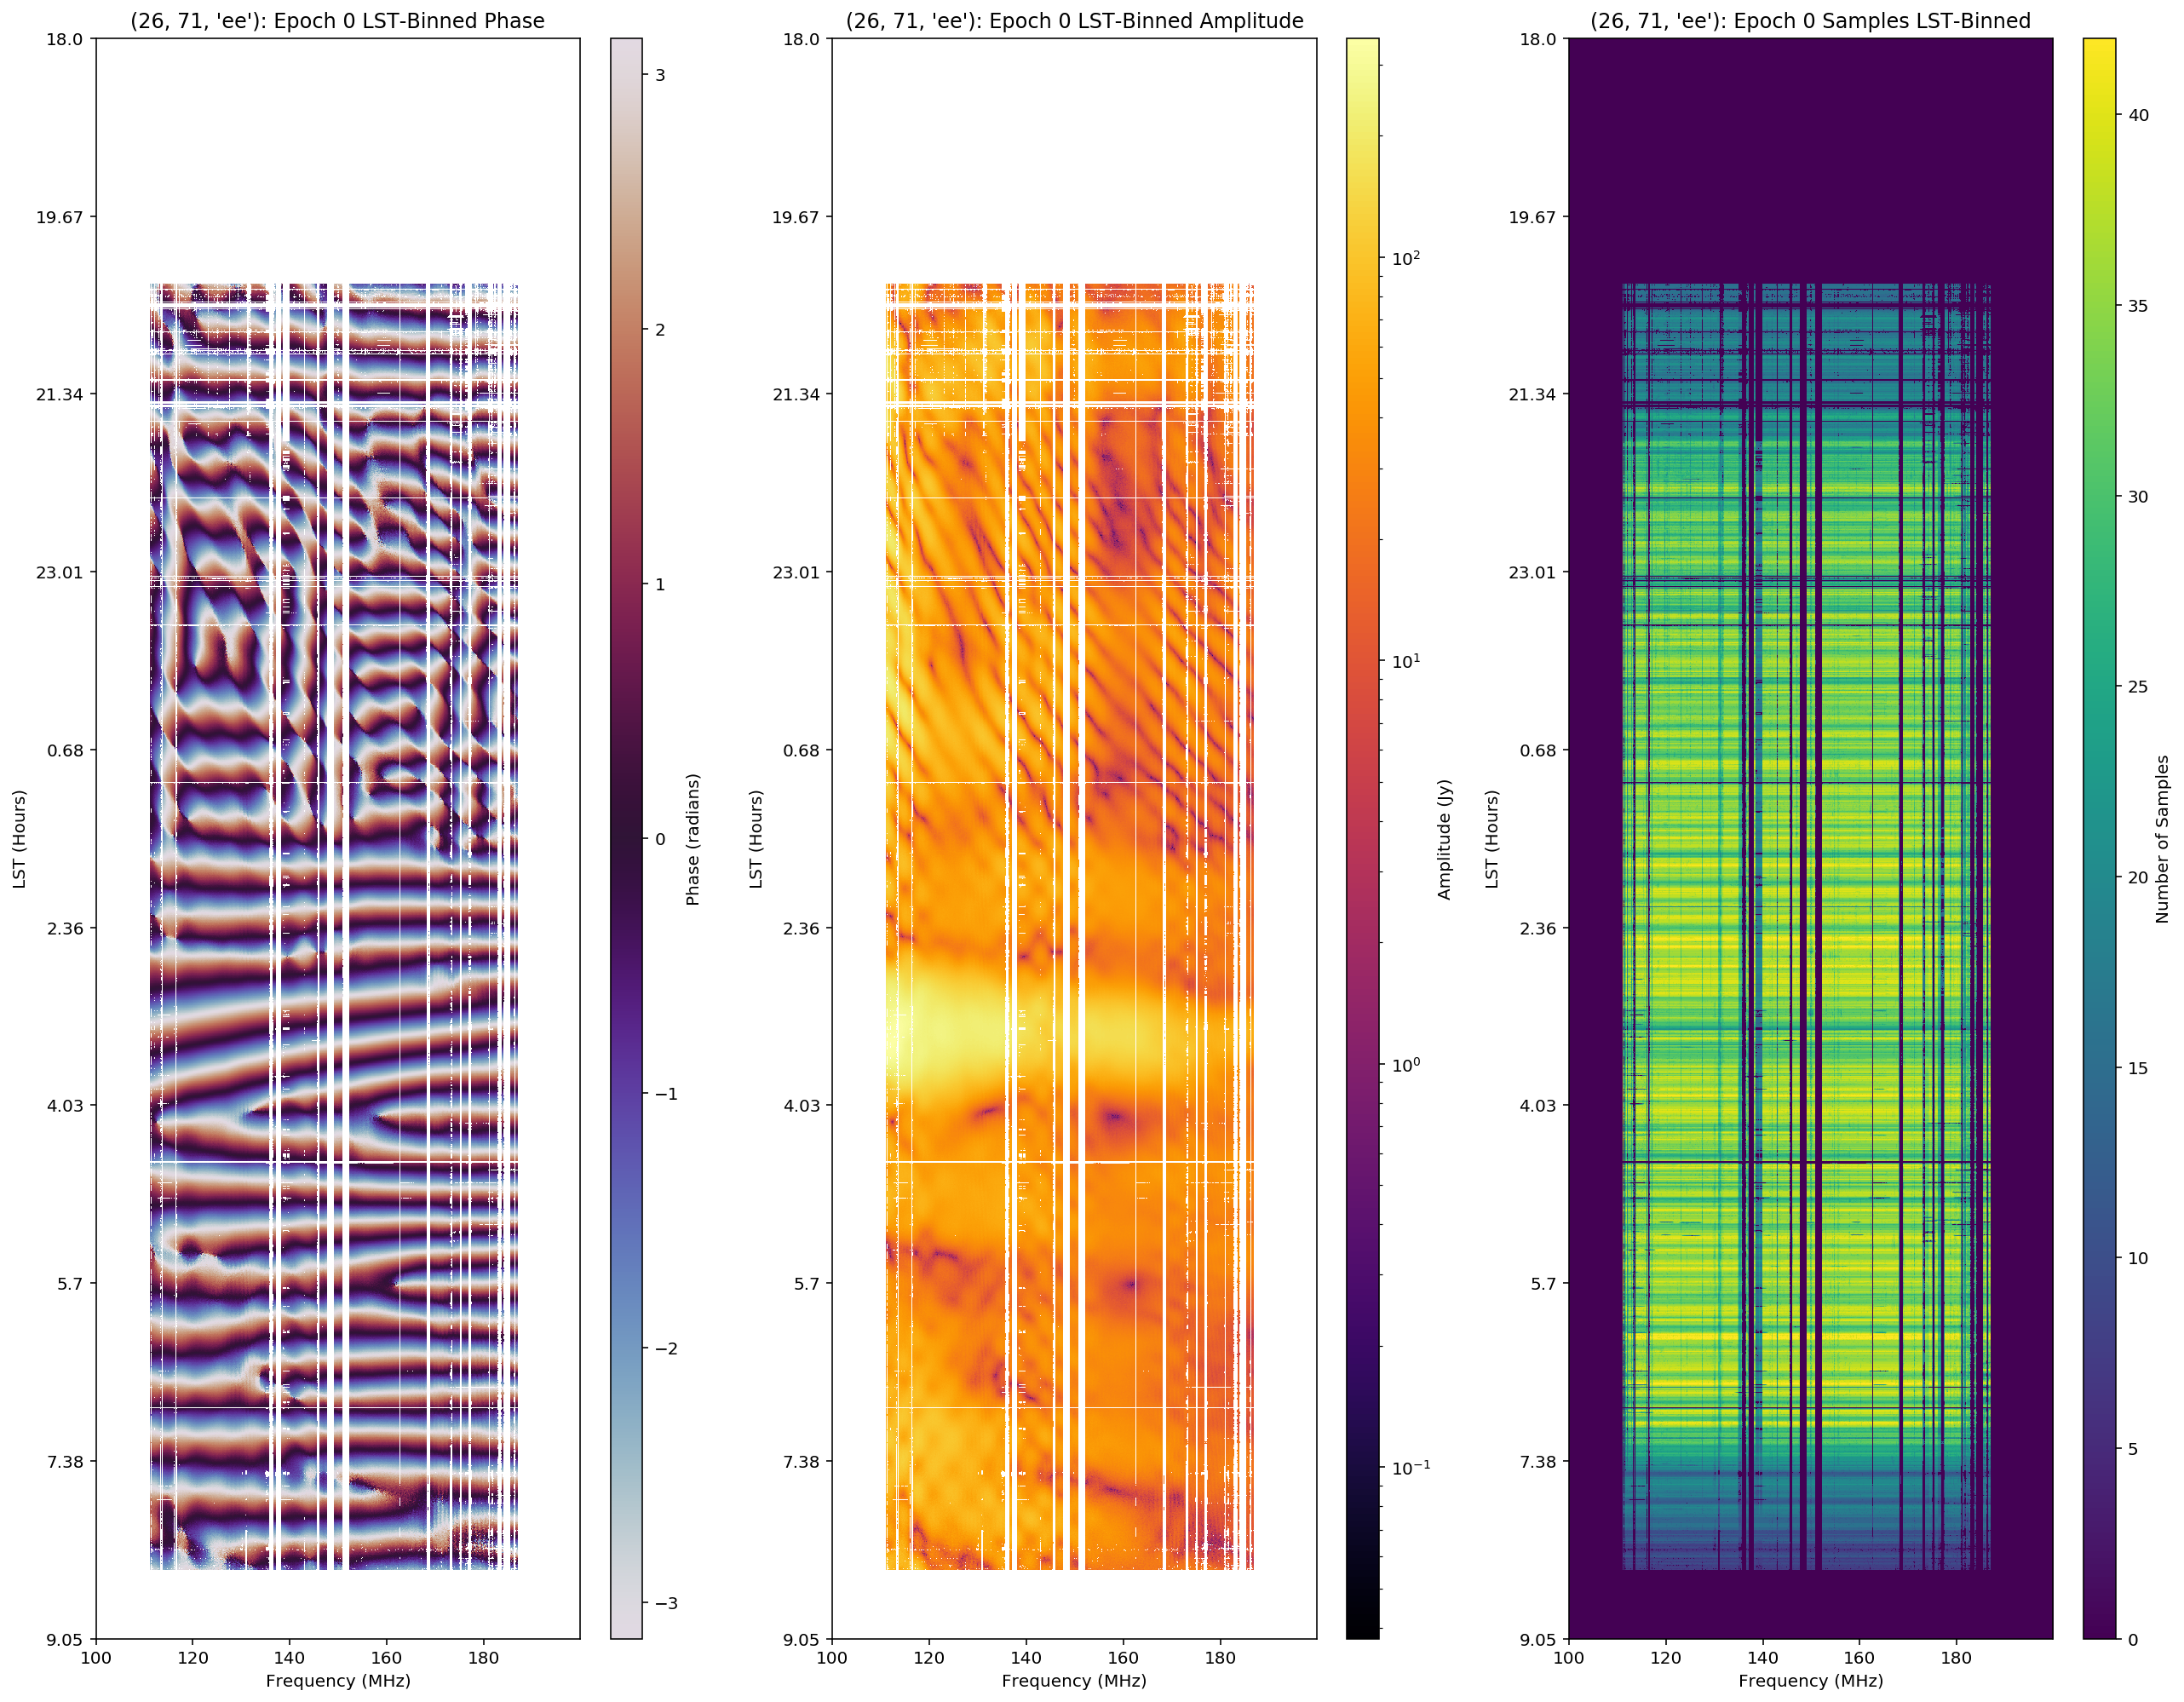

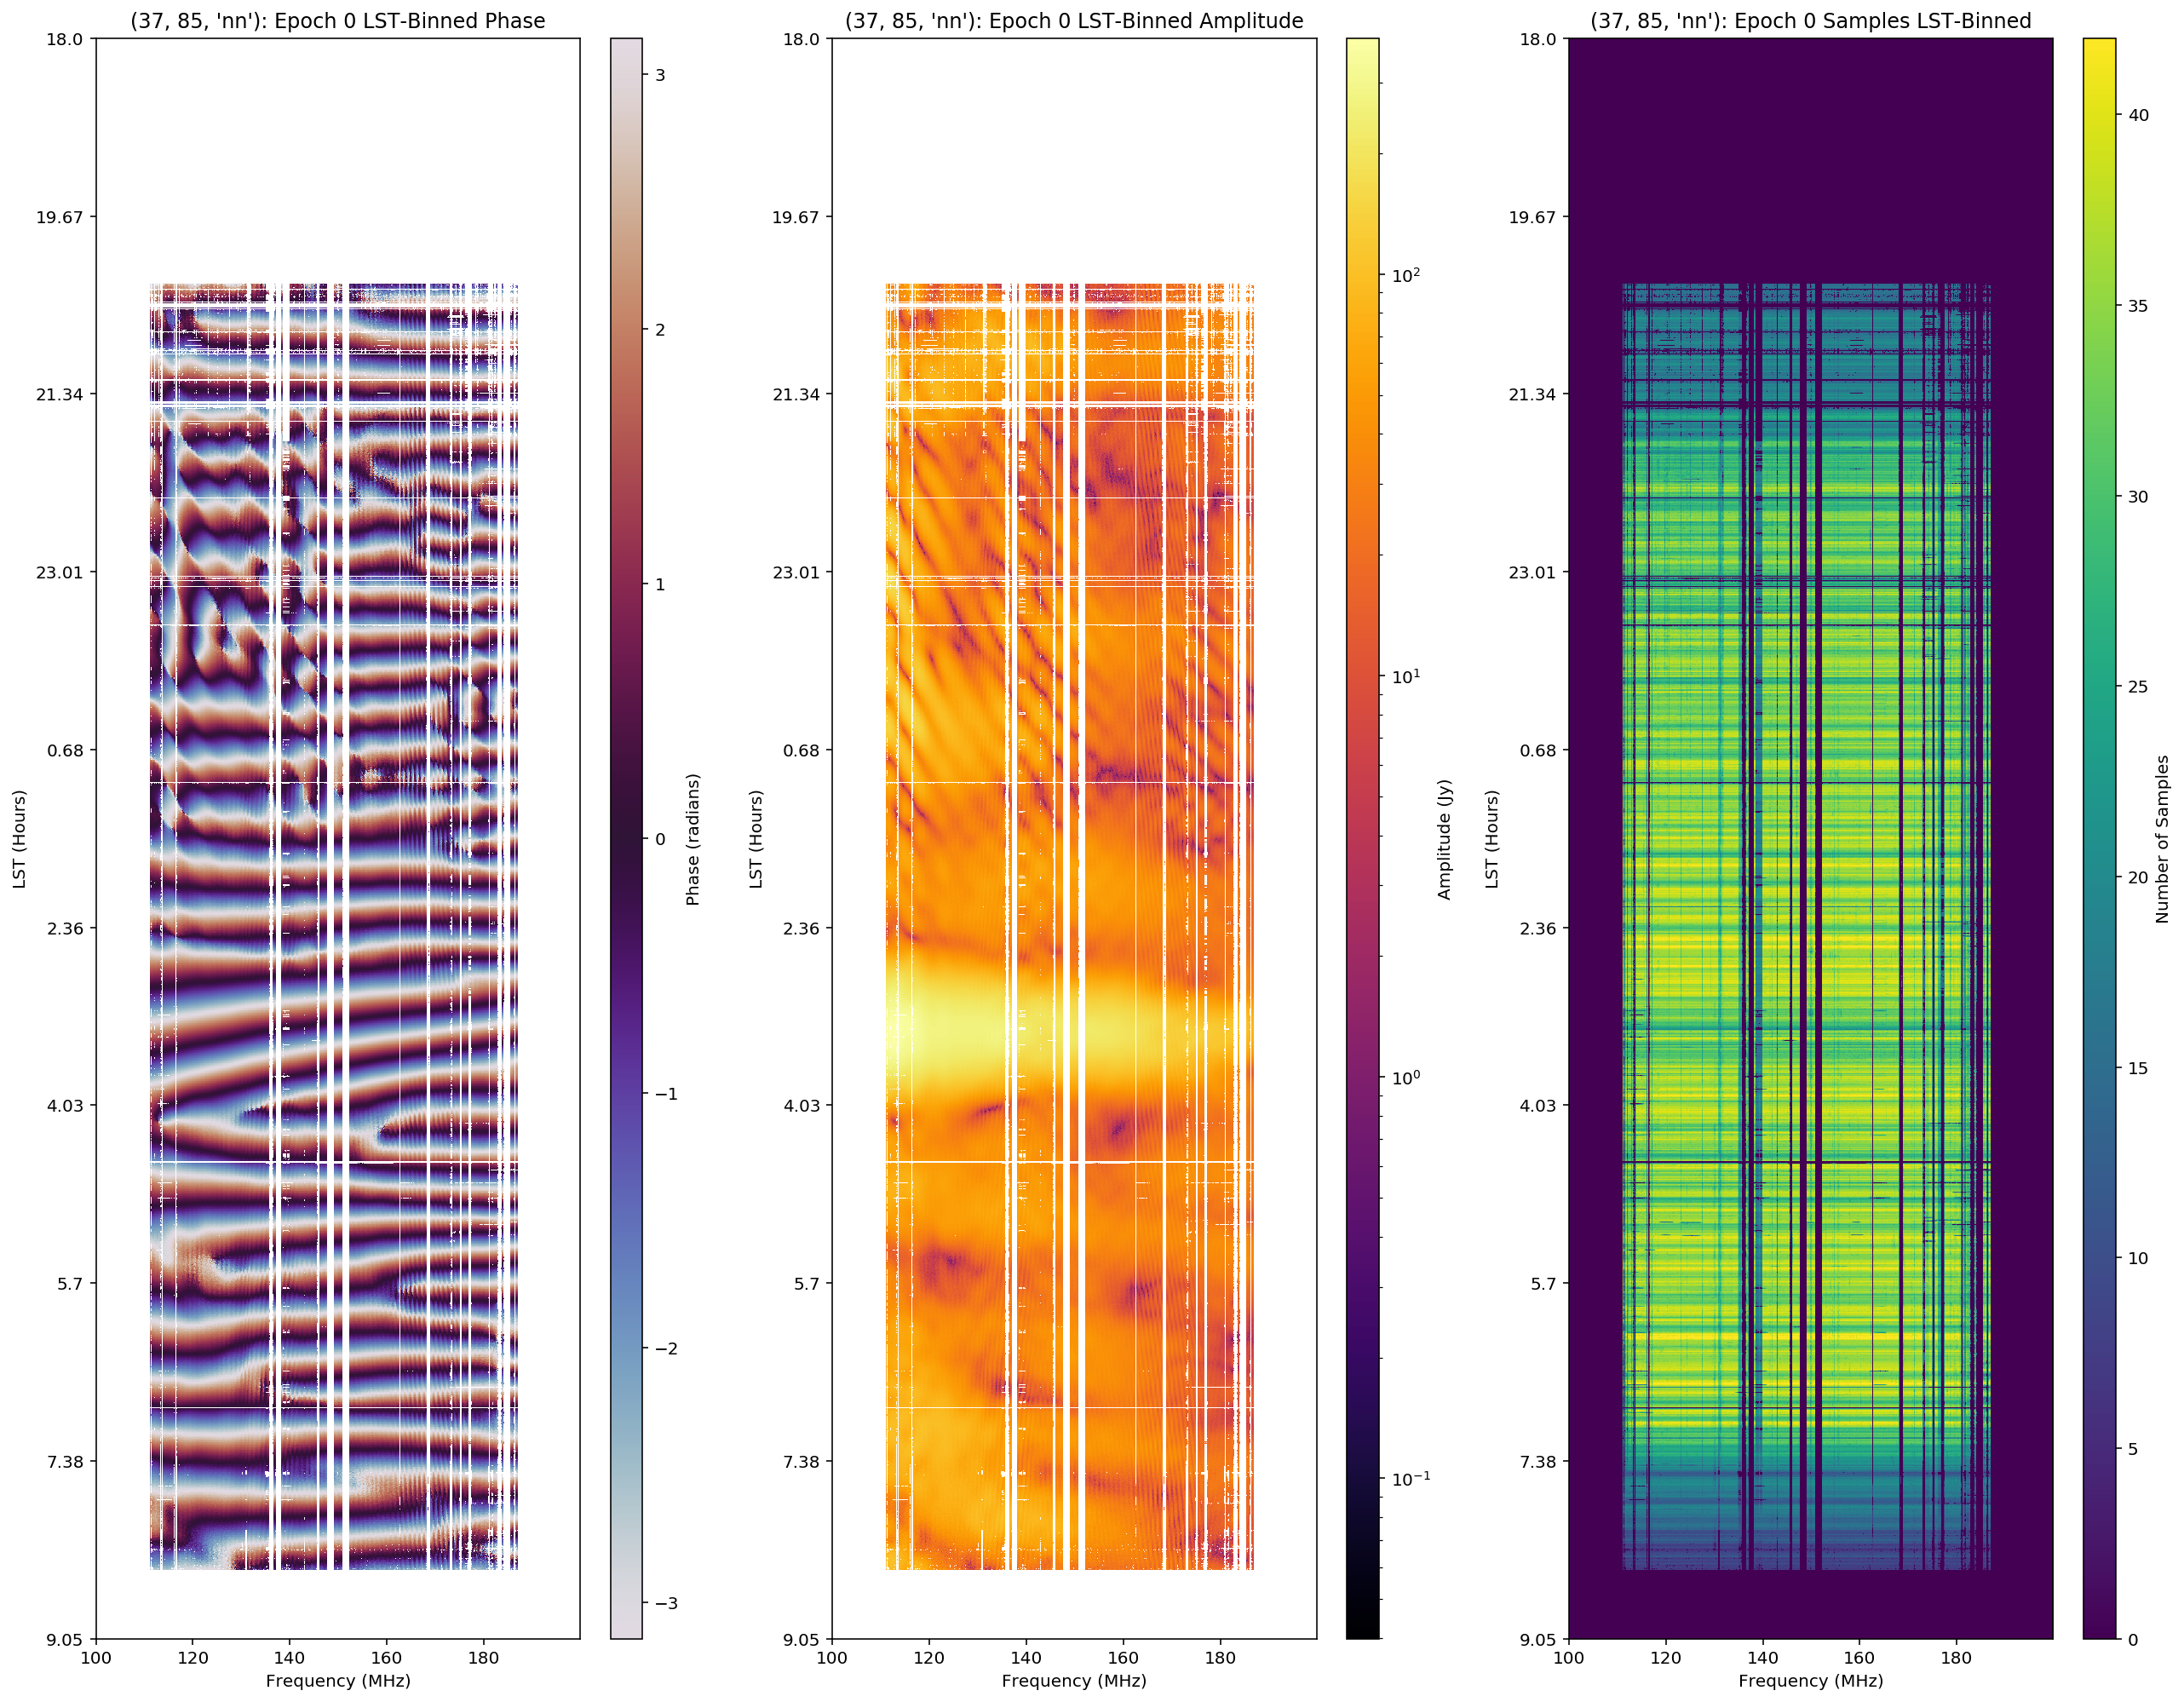

In [22]:
Plot_Full_Night()

# Metadata

In [23]:
print(lstbin.version.history_string())


------------
This file was produced by the function <module>() in <ipython-input-23-8fddb611bafd> using: 
    git_branch: master
    git_description: v3.0-733-gd2dd8ccf
    git_hash: d2dd8ccf3fe43d5e5eb6a4c28ceaf4a6e3d1fcb7
    git_origin: git@github.com:HERA-Team/hera_cal.git
    version: 3.0
------------

